<h1><center>Data Wrangling, Feature Engineering and EDA</center></h1>

This notebook contains code for the following:
1. Collate data from multiple csv files into a format that's usable for windowing and feature engineering
2. Build time windows with window length = 10 secs
3. Feature engineering of time domain, frequency domain and DCT (Discrete Cosine Transform) features
4. Exploratory Data Analysis


#### Import necessary libraries and set display options

In [1]:
import datetime as dt
import os
import pickle
import numpy as np
import pandas as pd
from math import ceil
from scipy import stats
import matplotlib.pyplot as plt
from detecta import detect_peaks
from scipy.signal import butter, lfilter
from scipy import fftpack

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',200)

### 1. Collate data from multiple csv files into a format that's usable for windowing and feature engineering

In [2]:
# Put data together from several csv files into a format that's usable for windowing and feature engineering

def build_dataset(data_store='../data'):
    csv_files_arr = []

    for directory in os.listdir(data_store):
        if os.path.isfile(os.path.join(data_store, directory)):
            continue
        sensor_placement = directory

        for subdirectory in os.listdir(os.path.join(data_store, directory)):
            if subdirectory.startswith(r'.'):
                continue
            if os.path.isfile(os.path.join(data_store, directory, subdirectory)):
                continue

            activity = subdirectory

            for filename in os.listdir(os.path.join(data_store, directory, subdirectory)):
                if filename.endswith('.csv'):
                    user = filename.replace('.csv', '')
                    csv_files_arr.append(
                        [os.path.abspath(os.path.join(data_store, directory, subdirectory, filename)), sensor_placement,
                         activity, user])

    person_data = {}

    for i, row in enumerate(csv_files_arr):
        path = row[0]
        sensor_placement = row[1]
        activity_class = row[2]
        user = row[3]

        if sensor_placement != 'w':
            continue

        if user in person_data:
            activity_data = person_data[user]
        else:
            activity_data = {}

        if activity_class in activity_data:
            activity_df = activity_data[activity_class]
        else:
            activity_df = pd.DataFrame()

        _df = pd.read_csv(path)
        
        if(np.sum(_df['y'].values)==0):
            print(user, activity_class)
            
        _df['m'] = np.sqrt(np.square(_df['x'].values) + np.square(_df['y'].values) + np.square(_df['z'].values))
        _df['user'] = user
        _df['activity_class'] = activity_class
        _df['epoch'] = _df['time'].apply(lambda x: ((dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f') -
                                                     dt.datetime.utcfromtimestamp(0)).total_seconds()) * 1000)

        try:
            _df.drop(columns=['class'], inplace=True)
        except KeyError:
            pass

        activity_df = pd.concat([activity_df, _df])
        activity_data[activity_class] = activity_df
        person_data[user] = activity_data
    return person_data


# person_data = build_dataset()

# store as a pickle file for easy access later
# with open('../data/wrist_dump.pkl', 'wb+') as f:
#     pickle.dump(person_data, f)


### 2. Build time windows with window length = 10 secs


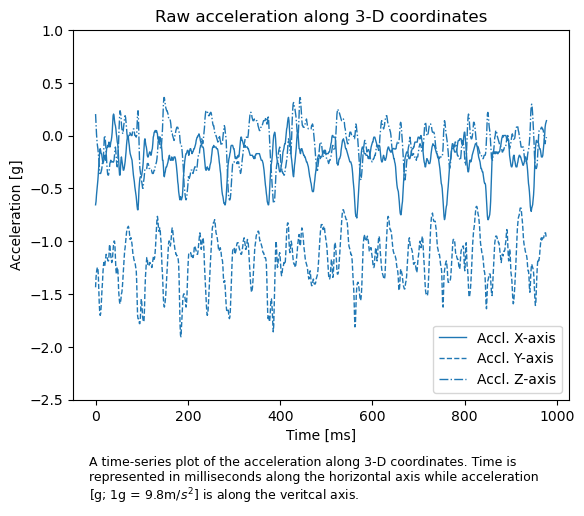

In [3]:
with open('../data/wrist_dump.pkl','rb') as f:
    person_data = pickle.load(f)

# define L1 classification labels
_label_map = {'standing': 'sedentary', 'sitting': 'sedentary', 'lying': 'sedentary', 'jogging': 'running',
              'walk_slow': 'walking', 'walk_mod': 'walking', 'walk_fast': 'walking', 'upstairs': 'stairs',
              'downstairs': 'stairs'}


def build_time_windows(_df, time_len=10, overlap_ratio=0.5, min_time_len=2,
                       sample_rate='auto', rate_calcref='epoch', sample_rate_multiplier=1000):
    if sample_rate == 'auto':
        sample_rate = (_df.shape[0] * sample_rate_multiplier) / (_df[rate_calcref].max() - _df[rate_calcref].min())

    elif isinstance(sample_rate, (int, float)):
        raise TypeError(
            "Parameter sample_rate expects int or float unless set to 'auto'; received {}".format(sample_rate))

    _twds = []
    idxwidth = ceil(sample_rate * time_len)
    min_idxwidth = ceil(sample_rate * min_time_len)
    increment = ceil(idxwidth * (1 - overlap_ratio))

    n = _df.shape[0]
    i = 0

    while i < n:
        start = i
        end = start + idxwidth

        if (end > n) or (n - end < min_idxwidth):
            end = n - 1
            i = n
        _dftw = _df.iloc[start:end].copy()
        _dftw['class'] = _dftw['activity_class'].map(_label_map)
        _dftw.drop(columns=['activity_class'], inplace=True)
        _twds.append(_dftw)
        i += increment

    return _twds


def plot_window_data(_sample_df):
    x = _sample_df['x']
    y = _sample_df['y']
    z = _sample_df['z']
    m = _sample_df['m']

    fig, ax = plt.subplots()
    ax.plot(np.linspace(0, x.size - 1, x.size), x, color='tab:blue', lw=1, label='Accl. X-axis')
    ax.plot(np.linspace(0, y.size - 1, y.size), y, color='tab:blue', linestyle='--', lw=1, label='Accl. Y-axis')
    ax.plot(np.linspace(0, z.size - 1, z.size), z, color='tab:blue', linestyle='-.', lw=1, label='Accl. Z-axis')
    ax.legend(loc='lower right')
    ax.set_ylim(-2.5, 1)

    ax.set_title('Raw acceleration along 3-D coordinates')
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Acceleration [g]')

    caption_text = r"""A time-series plot of the acceleration along 3-D coordinates. Time is 
represented in milliseconds along the horizontal axis while acceleration 
[g; 1g = 9.8m/$s^{2}$] is along the veritcal axis."""

    plt.figtext(0.15, -0.1, caption_text, wrap=False, horizontalalignment='left',
                fontsize=9)
    plt.savefig('../figures/sampled_timeseries.png', dpi=300, bbox_inches="tight")


time_windows = []
for person, activity_data in person_data.items():
    for activity, activity_df in activity_data.items():
        time_windows.append(build_time_windows(activity_df))

plot_window_data(time_windows[12][0])



### 3. Feature Engineering of  time domain and frequency domain features

##### 3.1 Time domain features

In [4]:
def build_time_domain_features(time_windows):
    """Build set of time domain features for each time window. Returns reduced dataframe"""

    def td_sum(x):
        return np.sum(x)

    def td_mean(x):
        return np.mean(x)

    def td_std(x):
        return np.std(x)

    def td_percentile(x, p):
        return np.percentile(x, p)

    def td_iqr(x):
        return np.percentile(x, 75) - np.percentile(x, 25)

    def td_range(x):
        return np.max(x) - np.min(x)

    def td_power(x):
        return np.sum(np.square(x))

    def td_log_power(x, eps=10e-6):
        x = np.add(x, eps)
        return np.sum(np.log(np.square(x)))

    def td_energy(x, y, z):
        ex = np.sqrt(np.sum(np.square(np.subtract(x, np.mean(x)))))
        ey = np.sqrt(np.sum(np.square(np.subtract(y, np.mean(y)))))
        ez = np.sqrt(np.sum(np.square(np.subtract(z, np.mean(z)))))

        e = (1 / (3 * len(x))) * (ex + ey + ez)
        return e

    def td_rms(x):
        return np.sqrt(np.mean(np.square(x)))
    
    def td_peakamp(x):
        return np.max(x)-np.min(x)
    
    def td_onelag_autocorr(x,k=1):
        x = np.array(x)
        xbar = np.mean(x)
        return (np.sum((x[k:len(x)]-xbar)*(x[k-1:len(x)-1]-xbar)))/(np.sum((x-xbar)**2))
    
    def td_skew(x):
        x = np.array(x)
        return stats.skew(x)
    
    def td_kurtosis(x):
        x = np.array(x)
        return stats.kurtosis(x)
    
    def td_corr(x,y):
        return np.corrcoef(x,y)[0,1]
    
    def td_max(x):
        return np.max(x)
    
    def td_min(x):
        return np.min(x)
    
    def td_mean_abs_dev(x):
        return np.mean(np.abs(x-np.mean(x)))
    
    def td_zerocross(x):
        x = np.array(x)
        k = np.argwhere(x<0).flatten() - np.argwhere(x>=0)
        return np.sum(k==-1)+np.sum(k==1)
    
    def td_mediancross(x):
        x = np.array(x)
        y = x-np.median(x)
        return td_zerocross(y)

    time_domain_func = [td_sum, td_mean, td_std, td_iqr, td_range, td_power, td_log_power, td_rms, td_energy,
                        td_peakamp, td_onelag_autocorr, td_skew, td_kurtosis, td_corr, td_max, td_min, 
                        td_zerocross]
    time_domain_col = ['epoch_start', 'epoch_end', 'user', 'class']

    for func in time_domain_func:
        if (func in [td_energy]):
            time_domain_col.append(func.__name__)
            continue
            
        if (func in [td_corr]):
            time_domain_col.append(func.__name__+'_xy')
            time_domain_col.append(func.__name__+'_yz')
            time_domain_col.append(func.__name__+'_zx')
            continue
            
        for axis in ['x', 'y', 'z', 'm']:
            time_domain_col.append(func.__name__ + '_' + axis)

    time_domain_features = []

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(),
                                  twdf['user'].unique()[0], twdf['class'].unique()[0]])

            for func in time_domain_func:
                if (func in [td_energy]):
                    twdf_features.extend([func(twdf['x'].values, twdf['y'].values, twdf['z'].values)])
                    continue
                    
                if (func in [td_corr]):
                    twdf_features.extend([func(twdf['x'].values,twdf['y'].values)])
                    twdf_features.extend([func(twdf['y'].values,twdf['z'].values)])
                    twdf_features.extend([func(twdf['z'].values,twdf['x'].values)])
                    continue
                    
                twdf_features.extend([func(twdf['x'].values), func(twdf['y'].values),
                                      func(twdf['z'].values), func(twdf['m'].values)])

            time_domain_features.append(twdf_features)

    time_domain_df = pd.DataFrame(time_domain_features, columns=time_domain_col)
    return time_domain_df

time_domain_df = build_time_domain_features(time_windows)
time_domain_df.head()

/var/folders/hz/mq1t9krj4kv9cxjz4g5c_p8c0000gn/T/ipykernel_34528/4056603532.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return (np.sum((x[k:len(x)]-xbar)*(x[k-1:len(x)-1]-xbar)))/(np.sum((x-xbar)**2))
/opt/miniconda3/envs/mlsemproj/lib/python3.10/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/miniconda3/envs/mlsemproj/lib/python3.10/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,epoch_start,epoch_end,user,class,td_sum_x,td_sum_y,td_sum_z,td_sum_m,td_mean_x,td_mean_y,td_mean_z,td_mean_m,td_std_x,td_std_y,td_std_z,td_std_m,td_iqr_x,td_iqr_y,td_iqr_z,td_iqr_m,td_range_x,td_range_y,td_range_z,td_range_m,td_power_x,td_power_y,td_power_z,td_power_m,td_log_power_x,td_log_power_y,td_log_power_z,td_log_power_m,td_rms_x,td_rms_y,td_rms_z,td_rms_m,td_energy,td_peakamp_x,td_peakamp_y,td_peakamp_z,td_peakamp_m,td_onelag_autocorr_x,td_onelag_autocorr_y,td_onelag_autocorr_z,td_onelag_autocorr_m,td_skew_x,td_skew_y,td_skew_z,td_skew_m,td_kurtosis_x,td_kurtosis_y,td_kurtosis_z,td_kurtosis_m,td_corr_xy,td_corr_yz,td_corr_zx,td_max_x,td_max_y,td_max_z,td_max_m,td_min_x,td_min_y,td_min_z,td_min_m,td_zerocross_x,td_zerocross_y,td_zerocross_z,td_zerocross_m
0,1.461149e+12,1.461149e+12,034,stairs,-338.875000,-940.234375,-107.218750,1038.139884,-0.347564,-0.964343,-0.109968,1.064759,0.260323,0.377101,0.183482,0.415666,0.226562,0.460938,0.187500,0.498218,2.390625,1.937500,1.640625,2.099636,183.854492,1045.358154,44.614746,1273.827393,-2400.145856,-204.390575,-5805.100453,-10.259216,0.434245,1.035453,0.213913,1.143018,0.008763,2.390625,1.937500,1.640625,2.099636,0.959971,0.977496,0.959807,0.979653,-0.779665,-1.062891,-0.644042,1.086734,4.229743,0.346434,3.186868,0.457005,0.435381,0.385052,-0.030118,0.718750,-0.312500,0.765625,2.461719,-1.671875,-2.25000,-0.875000,0.362082,18,0,60,0
1,1.461149e+12,1.461149e+12,034,stairs,-316.109375,-946.656250,-108.203125,1040.468241,-0.324215,-0.970929,-0.110978,1.067147,0.261514,0.368025,0.180813,0.397314,0.250000,0.484375,0.203125,0.508525,2.781250,1.953125,1.453125,2.016667,169.167236,1051.192871,43.884033,1264.244141,-2570.470164,-186.076819,-5653.900424,3.568909,0.416539,1.038338,0.212154,1.138710,0.008651,2.781250,1.953125,1.453125,2.016667,0.957153,0.977832,0.962883,0.976162,0.485764,-0.954958,-0.239081,0.960153,5.114670,0.085587,1.828126,0.060863,0.367344,0.334395,-0.001763,1.390625,-0.296875,0.703125,2.378749,-1.390625,-2.25000,-0.750000,0.362082,24,0,60,0
2,1.461149e+12,1.461149e+12,034,stairs,-311.218750,-946.265625,-117.875000,1034.081133,-0.319199,-0.970529,-0.120897,1.060596,0.215161,0.322750,0.181061,0.341776,0.203125,0.343750,0.203125,0.423340,2.390625,1.765625,1.437500,1.649355,144.477539,1019.941162,46.214355,1210.633057,-2598.059826,-154.847474,-4989.097434,24.533427,0.384944,1.022787,0.217714,1.114305,0.007675,2.390625,1.765625,1.437500,1.649355,0.953055,0.973531,0.965684,0.970502,1.026123,-1.095277,0.016828,1.080326,9.137590,0.563960,1.464564,0.413192,0.307107,0.223259,0.026833,1.390625,-0.296875,0.703125,2.175525,-1.000000,-2.06250,-0.734375,0.526171,16,0,55,0
3,1.461149e+12,1.461149e+12,034,stairs,-290.687500,-948.281250,-140.656250,1032.910278,-0.298141,-0.972596,-0.144263,1.059395,0.211231,0.303750,0.168489,0.314001,0.187500,0.296875,0.210938,0.288431,1.937500,1.703125,1.125000,1.718577,130.168945,1012.252441,47.970215,1190.391602,-2539.890283,-140.682956,-4527.122899,35.874748,0.365386,1.018925,0.221811,1.104950,0.007296,1.937500,1.703125,1.125000,1.718577,0.963273,0.979026,0.972322,0.977918,1.237579,-1.150361,0.360066,1.236757,5.970600,1.325820,1.113282,1.655382,0.436324,0.167722,0.200578,0.828125,-0.359375,0.500000,2.210206,-1.109375,-2.06250,-0.625000,0.491629,14,0,39,0
4,1.461149e+12,1.461149e+12,034,stairs,-323.875000,-933.843750,-103.156250,1028.847612,-0.332179,-0.957788,-0.105801,1.055228,0.239908,0.319935,0.167989,0.336932,0.250000,0.367188,0.203125,0.353418,1.937500,1.609375,1.218750,1.718577,163.701660,994.224121,38.428711,1196.354492,-2399.338411,-184.820264,-5024.393563,13.861764,0.409755,1.009810,0.198530,1.107714,0.007770,1.937500,1.609375,1.218750,1.718577,0.969032,0.974823,0.966819,0.974130,0.794674,-0.967885,-0.137721,1.021182,3.747348,0.441931,1.015949,0.634787,0.417741,0.312394,0.090313,0.828125,-0.359375,0.500000,2.210206,-1.109375,-1.96875,-0.718750,0.491629,14,0,43,0


##### 3.2 Frequency domain features

In [5]:
def build_freq_domain_features(time_windows):
    """Build set of frequency domain features for each time window. Returns reduced dataframe"""
    
    def run_fft(x, t):
        n = x.size
        dt = t / n
        df = 1 / t

        X = np.fft.fft(x)
        freqs = np.fft.fftfreq(n) * n * df

        if n % 2 == 0:
            eff_size = int(n / 2)
        else:
            eff_size = int((n + 1) / 2)
            
        return (X,freqs,eff_size)

    def fd_dominant_freq(x, t):
        """Returns the dominant frequency of x in Hz."""
        X,freqs,eff_size = run_fft(x, t)
        idx = np.argmax(np.abs(X[1:eff_size]))
        freq = freqs[1:eff_size][idx]
        return freq

    def fd_spectral_entropy(x):
        """Returns the spectral entropy of a signal"""
        n = x.size
        p = np.square(x) / n
        pi = p / np.sum(p) + 1e-15
        H = -np.sum(pi * np.log2(pi)) / (np.log2(n))
        return H

    def fd_step_counter(m):
        """Estimates number of steps based on number of peaks in the mag vector"""

        def _filter_signal(x, samp_rate=100, high=2, order=5):
            nyq = 0.5 * samp_rate
            high = high / nyq
            b, a = butter(order, high)
            y = lfilter(b, a, x)
            return y

        y = _filter_signal(m, samp_rate=100, high=2)
        peaks = detect_peaks(y, mph=1.2)
        steps = len(peaks)
        return steps
    
    
    def fd_spectral_centroid(x, t):
        """Returns the spectral centroid of a signal"""
        
        X,freqs,eff_size = run_fft(x, t)
        return np.sum(np.abs(X[1:eff_size])*freqs[1:eff_size])/np.sum(np.abs(X[1:eff_size]))
        

    freq_domain_func = [fd_dominant_freq, fd_step_counter, fd_spectral_entropy, fd_spectral_centroid]
    freq_domain_col = ['epoch_start', 'epoch_end', 'user', 'class']

    for func in freq_domain_func:
        for axis in ['x', 'y', 'z', 'm']:
            freq_domain_col.append(func.__name__ + '_' + axis)

    freq_domain_features = []

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(),
                                  twdf['user'].unique()[0], twdf['class'].unique()[0]])

            signal_secs = (twdf['epoch'].max() - twdf['epoch'].min()) / 1000

            for func in freq_domain_func:
                if func in [fd_dominant_freq, fd_spectral_centroid]:
                    twdf_features.extend([func(twdf['x'].values, signal_secs), func(twdf['y'].values, signal_secs),
                                          func(twdf['z'].values, signal_secs), func(twdf['m'].values, signal_secs)])
                else:
                    twdf_features.extend([func(twdf['x'].values), func(twdf['y'].values),
                                          func(twdf['z'].values), func(twdf['m'].values)])

            freq_domain_features.append(twdf_features)

    freq_domain_df = pd.DataFrame(freq_domain_features, columns=freq_domain_col)
    return freq_domain_df

freq_domain_df = build_freq_domain_features(time_windows)
freq_domain_df.head()

/var/folders/hz/mq1t9krj4kv9cxjz4g5c_p8c0000gn/T/ipykernel_34528/2633700651.py:30: RuntimeWarning: invalid value encountered in true_divide
  pi = p / np.sum(p) + 1e-15
/var/folders/hz/mq1t9krj4kv9cxjz4g5c_p8c0000gn/T/ipykernel_34528/2633700651.py:54: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(np.abs(X[1:eff_size])*freqs[1:eff_size])/np.sum(np.abs(X[1:eff_size]))


,epoch_start,epoch_end,user,class,fd_dominant_freq_x,fd_dominant_freq_y,fd_dominant_freq_z,fd_dominant_freq_m,fd_step_counter_x,fd_step_counter_y,fd_step_counter_z,fd_step_counter_m,fd_spectral_entropy_x,fd_spectral_entropy_y,fd_spectral_entropy_z,fd_spectral_entropy_m,fd_spectral_centroid_x,fd_spectral_centroid_y,fd_spectral_centroid_z,fd_spectral_centroid_m
0,1.461149e+12,1.461149e+12,034,stairs,2.000600,1.700510,1.500450,1.700510,0,0,0,13,0.908280,0.958818,0.836516,0.958852,7.112189,6.890545,6.536591,6.761240
1,1.461149e+12,1.461149e+12,034,stairs,3.501751,1.700850,1.700850,1.700850,0,0,0,13,0.916588,0.961436,0.859245,0.962591,7.398817,5.996705,7.661452,6.608010
2,1.461149e+12,1.461149e+12,034,stairs,3.402382,1.701191,1.701191,1.701191,0,0,0,13,0.931042,0.969089,0.875511,0.970831,7.742718,6.893951,7.761602,7.539699
3,1.461149e+12,1.461149e+12,034,stairs,2.299540,1.599680,1.599680,1.599680,0,0,0,12,0.944229,0.972427,0.906565,0.974805,6.960137,5.847475,6.606708,5.915038
4,1.461149e+12,1.461149e+12,034,stairs,3.102172,1.501051,1.601121,1.501051,0,0,0,13,0.937462,0.969243,0.883607,0.971535,6.822231,7.413753,7.972196,7.656319


##### 3.3 DCT features

In [6]:
def build_dct_domain_features(time_windows):

    dct_axis = ['x','y','z','m']
    dct_col = ['epoch_start', 'epoch_end', 'user', 'class']
    dct_features = []
    n_comps = 48

    for ax in dct_axis:
        dct_col.extend(['{}_dctcomp{}'.format(ax,i) for i in range(n_comps)])

    for useract_winset in time_windows:
        for twdf in useract_winset:
            twdf_features = []
            twdf_features.extend([twdf['epoch'].min(), twdf['epoch'].max(),
                                  twdf['user'].unique()[0], twdf['class'].unique()[0]])

            dct_x = np.abs(fftpack.dct(twdf['x'].values))[:n_comps].tolist()
            dct_y = np.abs(fftpack.dct(twdf['y'].values))[:n_comps].tolist()
            dct_z = np.abs(fftpack.dct(twdf['z'].values))[:n_comps].tolist()
            dct_m = np.abs(fftpack.dct(twdf['m'].values))[:n_comps].tolist()

            twdf_features.extend(dct_x)
            twdf_features.extend(dct_y)
            twdf_features.extend(dct_z)
            twdf_features.extend(dct_m)

            dct_features.append(twdf_features)

    dct_domain_df = pd.DataFrame(dct_features, columns=dct_col)
    return dct_domain_df

dct_domain_df = build_dct_domain_features(time_windows)
print(dct_domain_df.shape)
dct_domain_df.head()

(9381, 196)


,epoch_start,epoch_end,user,class,x_dctcomp0,x_dctcomp1,x_dctcomp2,x_dctcomp3,x_dctcomp4,x_dctcomp5,x_dctcomp6,x_dctcomp7,x_dctcomp8,x_dctcomp9,x_dctcomp10,x_dctcomp11,x_dctcomp12,x_dctcomp13,x_dctcomp14,x_dctcomp15,x_dctcomp16,x_dctcomp17,x_dctcomp18,x_dctcomp19,x_dctcomp20,x_dctcomp21,x_dctcomp22,x_dctcomp23,x_dctcomp24,x_dctcomp25,x_dctcomp26,x_dctcomp27,x_dctcomp28,x_dctcomp29,x_dctcomp30,x_dctcomp31,x_dctcomp32,x_dctcomp33,x_dctcomp34,x_dctcomp35,x_dctcomp36,x_dctcomp37,x_dctcomp38,x_dctcomp39,x_dctcomp40,x_dctcomp41,x_dctcomp42,x_dctcomp43,x_dctcomp44,x_dctcomp45,...,z_dctcomp46,z_dctcomp47,m_dctcomp0,m_dctcomp1,m_dctcomp2,m_dctcomp3,m_dctcomp4,m_dctcomp5,m_dctcomp6,m_dctcomp7,m_dctcomp8,m_dctcomp9,m_dctcomp10,m_dctcomp11,m_dctcomp12,m_dctcomp13,m_dctcomp14,m_dctcomp15,m_dctcomp16,m_dctcomp17,m_dctcomp18,m_dctcomp19,m_dctcomp20,m_dctcomp21,m_dctcomp22,m_dctcomp23,m_dctcomp24,m_dctcomp25,m_dctcomp26,m_dctcomp27,m_dctcomp28,m_dctcomp29,m_dctcomp30,m_dctcomp31,m_dctcomp32,m_dctcomp33,m_dctcomp34,m_dctcomp35,m_dctcomp36,m_dctcomp37,m_dctcomp38,m_dctcomp39,m_dctcomp40,m_dctcomp41,m_dctcomp42,m_dctcomp43,m_dctcomp44,m_dctcomp45,m_dctcomp46,m_dctcomp47
0,1.461149e+12,1.461149e+12,034,stairs,677.75000,13.904060,27.820161,20.216031,14.808464,24.060283,6.844676,8.337350,18.166224,11.843695,3.833079,11.047315,11.514696,9.215306,8.290175,36.200134,46.368982,9.313669,12.925500,13.805901,7.736759,23.386592,3.997330,23.744369,25.136973,43.373741,5.929748,6.936913,3.696463,1.971157,19.575798,69.217419,22.703205,27.292842,50.743913,10.160814,2.380959,33.110709,11.786888,40.214640,84.606217,55.201958,6.675851,57.541971,52.024734,7.537803,...,1.925406,50.861361,2076.279768,10.157793,9.265464,11.843272,5.871812,11.843561,0.757868,38.658524,5.585116,43.976810,10.533122,47.702128,0.063597,12.949194,40.480915,69.099839,3.608319,11.315713,36.711139,0.426223,9.648678,31.753076,28.226011,31.529906,27.832247,77.290785,55.646372,49.473869,1.108228,21.714411,14.623038,261.956541,21.798399,143.492762,107.669180,63.737308,6.068691,95.304485,85.683191,55.263554,153.253896,79.287005,33.865088,163.907296,41.425424,9.270936,15.411860,79.784458
1,1.461149e+12,1.461149e+12,034,stairs,632.21875,9.602325,19.091294,67.523595,27.868726,17.896868,25.945808,25.093488,0.469920,26.497085,2.442654,0.958154,15.079478,2.127690,5.605306,9.022919,26.769142,33.114694,5.388710,14.573172,28.868019,2.958345,18.628581,9.045691,14.942073,18.007881,8.661218,33.419793,16.278974,14.139195,39.811353,10.564472,5.540954,72.439683,69.036792,17.038295,27.983779,8.558526,37.253650,46.483233,61.510031,63.321870,7.658990,3.263777,46.723184,41.934434,...,0.245972,5.448570,2080.936481,5.612973,5.320005,17.739145,15.062990,2.844927,6.864910,3.941708,21.572162,19.793367,13.535750,9.796042,12.558944,25.548996,17.770863,6.806148,20.491572,46.201970,38.319913,51.618180,1.767413,28.424608,0.427108,1.688910,4.812420,59.152919,49.057062,47.459846,56.054352,20.268735,52.600327,12.802408,83.529046,257.808700,222.323323,21.978855,22.099329,44.177583,56.220834,21.395832,141.668952,126.865771,27.856653,6.584262,107.601779,15.958309,17.535993,32.404370
2,1.461149e+12,1.461149e+12,034,stairs,622.43750,27.036644,31.998418,27.792843,55.602453,24.853602,22.543622,31.727509,16.085823,6.868457,4.314579,11.733305,7.998321,16.474490,5.243512,20.792925,29.231215,6.824746,7.896972,19.459795,4.520184,8.487904,13.544688,17.497244,8.527660,4.309132,10.705455,3.494315,27.670948,21.248034,24.556979,34.396770,17.372779,13.101129,67.353088,46.189464,30.234603,16.634266,17.400803,12.932579,16.127222,5.065032,29.161921,8.192062,5.158907,32.081611,...,3.792675,8.327492,2068.162266,3.134745,4.800353,32.427464,5.592643,29.536413,0.382774,7.931111,11.069372,8.783422,10.631017,51.393913,9.889443,49.511218,0.850456,28.452707,2.974405,4.993287,12.887522,44.891174,8.609164,31.166180,4.748501,1.644339,11.459698,21.678533,51.402734,75.007264,20.110374,89.783620,65.063223,90.382000,1.204429,26.345652,244.484815,143.991900,58.284420

##### 3.4 Merge time, frequency and DCT dataframes

In [7]:
time_freq_domain_df = pd.merge(left=time_domain_df, right=freq_domain_df, left_index=True, right_index=True,
                               how='inner', suffixes=('', '_drop'))
time_freq_domain_df.drop(columns=[col_name for col_name in time_freq_domain_df.columns if '_drop' in col_name],
                         inplace=True)

time_freq_dct_domain_df = pd.merge(left=time_freq_domain_df, right=dct_domain_df, left_index=True, right_index=True,
                                   how='inner', suffixes=('', '_drop'))
time_freq_dct_domain_df.drop(columns=[col_name for col_name in time_freq_domain_df.columns if '_drop' in col_name],
                             inplace=True)


time_freq_dct_domain_df.shape


(9381, 280)

### 4. Exploratory Data Analysis

In [8]:
# Functions critical for plotting

def build_label_color_map(class_labels, color_map=plt.cm.tab10):
    label_color_map = {}
    for i,label in enumerate(class_labels):
        label_color_map[label] = color_map(i)
    return label_color_map

def build_colormap(labels_arr, label_color_map):
    color_arr = []
    for label in labels_arr:
        color_arr.append(label_color_map[label])
    return color_arr


def build_grouped_boxplots(df, group_feature, agg_feature, group_custom_order=None,
                           plot_title=None, xlabel=None, ylabel=None, caption=None, 
                           caption_position=None, file_name=None):
    """Build a boxplot grouped by one feature for one aggregation feature."""

    groupdf = df.groupby([group_feature]).agg({agg_feature: lambda x: list(x)})
    groupdf = groupdf.reset_index().set_index(group_feature)
    groupdf = groupdf.sort_values(by=[group_feature], key=lambda x: x.map(group_custom_order))
    groupdict = groupdf.to_dict()[agg_feature]

    fig, ax = plt.subplots()
    bp = ax.boxplot(groupdict.values(), sym='.', medianprops=dict(color='tab:green'))
    ax.tick_params(axis='both', which='major', labelsize=9)

    if plot_title:
        ax.set_title(plot_title, fontsize=11)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=10, labelpad=8)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=10, labelpad=8)

    if caption:
        try:
            ax.text(caption_position[0], caption_position[1], caption, wrap=False, horizontalalignment='left', fontsize=9)
        except:
            ax.text(0.7, -0.15, caption, wrap=False, horizontalalignment='left', fontsize=9)

    if isinstance(group_custom_order, dict):
        ax.set_xticklabels(group_custom_order.keys(), fontdict=dict(fontsize=9))
    plt.grid(True, which='major', color='0.8', linestyle='-')

    if file_name:
        plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
    else:
        plt.show()


##### 4.1 Check for missing values

In [9]:
# Basic EDA to understand different column types, null values, range, etc. of each feature in the dataset
import operator

def custom_describe(df):
    desc_dict = dict()

    for col in df.columns:
        nunique = df[col].nunique()
        count = df[col].count()
        nnull = df[df[col].isnull()].shape[0]
        null_ratio = df[df[col].isnull()].shape[0]/(df[df[col].isnull()].shape[0]+df[col].count())

        try:
            mean = df[col].mean()
            std = df[col].std()
            min_val = df[col].min()
            max_val = df[col].max()
            p25 = df[col].quantile(0.25)
            p50 = df[col].quantile(0.5)
            p75 = df[col].quantile(0.75)
            feature_type = 'numeric'
        except TypeError:
            mean = np.NaN
            std = np.NaN
            min_val = np.NaN
            max_val = np.NaN
            p25 = np.NaN
            p50 = np.NaN
            p75 = np.NaN
            feature_type = 'categorical-text'

        dtype = df[col].dtypes.__str__()
        top5dict = df[col].value_counts(sort=True, ascending=False, dropna=False).to_dict()
        top5 = dict(sorted(top5dict.items(), key=operator.itemgetter(1), reverse=True)[:5])

        bottom5dict = df[col].value_counts(sort=True, ascending=True, dropna=False).to_dict()
        bottom5 = dict(sorted(bottom5dict.items(), key=operator.itemgetter(1), reverse=False)[:5])

        output_values = [feature_type, dtype, nunique, count, nnull, null_ratio, mean, std, min_val, max_val,
                         p25, p50, p75, top5, bottom5]
        desc_dict[col] = output_values

    custom_summary_df = pd.DataFrame(data=desc_dict.values(),
                                     columns=['feature_type','dtype','nunique','count','nnull','null_ratio','mean','std',
                                              'min_val','max_val','p25','p50','p75','top5','bottom5'],
                                     index=desc_dict.keys())
    return custom_summary_df

feature_desc = custom_describe(time_freq_dct_domain_df)
print('Data types and ratio of null/NaN values are as follows: \n')

feature_desc[feature_desc['null_ratio']>0]


Data types and ratio of null/NaN values are as follows: 



,feature_type,dtype,nunique,count,nnull,null_ratio,mean,std,min_val,max_val,p25,p50,p75,top5,bottom5
td_onelag_autocorr_y,numeric,float64,9376,9380,1,0.000107,0.854029,0.228002,-0.171293,0.998959,0.841934,0.968901,0.979270,"{0.0: 4, 0.16666666666666666: 2, 0.97749640731...","{0.9774964073106952: 1, 0.6033385477462686: 1,..."
td_skew_y,numeric,float64,9371,9380,1,0.000107,-0.162798,1.261210,-22.371902,22.056791,-0.594091,-0.216113,0.166340,"{0.0: 8, 0.9875863831316736: 2, 7.277543860855...","{-1.0628914391533155: 1, 1.700314580264467: 1,..."
td_kurtosis_y,numeric,float64,9379,9380,1,0.000107,3.869027,18.922611,-1.999933,498.501990,-0.507039,0.177265,1.718713,"{160.16666666666669: 2, -0.6577161373160383: 1...","{0.34643447811041117: 1, 10.377425150900073: 1..."
td_corr_xy,numeric,float64,9375,9380,1,0.000107,0.053727,0.298710,-0.968202,0.920288,-0.128942,0.067158,0.278584,"{0.0: 6, 0.43538099067914926: 1, 0.30845724276...","{0.43538099067914926: 1, -0.0637429098664212: ..."
td_corr_yz,numeric,float64,9379,9380,1,0.000107,-0.004499,0.302496,-0.975104,0.979252,-0.180808,0.003339,0.178140,"{0.0: 2, 0.38505182041736297: 1, -0.2232146682...","{0.38505182041736297: 1, -0.2743333851849705: ..."
fd_spectral_entropy_y,numeric,float64,9375,9380,1,0.000107,0.968390,0.056529,0.159389,0.999999,0.957088,0.986933,0.996397,"{0.9999342989931009: 2, 0.99994165442842: 2, 0...","{0.9588180895355758: 1, 0.9999681002259763: 1,..."
fd_spectral_centroid_y,numeric,float64,9380,9380,1,0.000107,11.111252,5.689761,2.847852,28.120680,6.838070,8.354213,15.454545,"{6.890545040070402: 1, 6.968214935999695: 1, 1...","{6.890545040070402: 1, 21.575309607204257: 1, ..."


In [10]:
# Dropping rows with missing values since its only one row
try:
    time_freq_domain_df.drop(index=time_freq_domain_df[time_freq_domain_df['td_onelag_autocorr_y'].isnull()].index[0],
                             inplace=True)
except IndexError:
    pass

try:
    time_freq_dct_domain_df.drop(index=time_freq_dct_domain_df[time_freq_dct_domain_df['td_onelag_autocorr_y'].isnull()].index[0],
                                 inplace=True)
except IndexError:
    pass

# save each to a csv for easier access, if needed
time_domain_df.to_csv('../data/time_domain_windows.csv', index=False)
freq_domain_df.to_csv('../data/freq_domain_windows.csv', index=False)
dct_domain_df.to_csv('../data/dct_windows.csv', index=False)
time_freq_domain_df.to_csv('../data/time_freq_domain_windows.csv', index=False)
time_freq_dct_domain_df.to_csv('../data/time_freq_dct_domain_windows.csv', index=False)



##### 4.2 Class balance

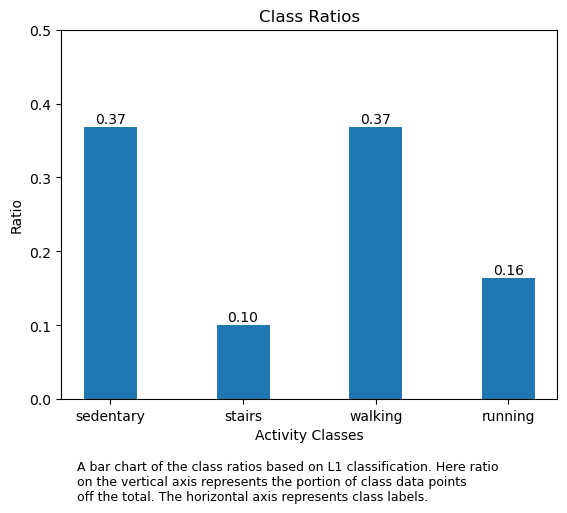

In [11]:
class_custom_order = {'sedentary':0,'stairs':1,'walking':2,'running':3}
class_balance = time_freq_domain_df['class'].value_counts()/time_freq_domain_df['class'].value_counts().sum()
class_balance.sort_index(key=lambda x: x.map(class_custom_order),inplace=True)

fig,ax = plt.subplots()
ax.bar(x=class_balance.index, height=class_balance.values, width=0.4)
ax.set_title('Class Ratios')
ax.set_xlabel('Activity Classes')
ax.set_ylabel('Ratio')
ax.set_ylim(0,0.5)

rects = ax.patches

# Make labels
labels = ['{:.02f}'.format(i) for i in class_balance.values]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.001, label, ha="center", va="bottom")

caption_text = r"""A bar chart of the class ratios based on L1 classification. Here ratio 
on the vertical axis represents the portion of class data points 
off the total. The horizontal axis represents class labels."""

plt.figtext(0.15, -0.1, caption_text, wrap=False, horizontalalignment='left',
            fontsize=9)
# plt.show()
plt.savefig('../figures/class_ratios.png', dpi=300, bbox_inches="tight")


##### 4.3 Time domain plots

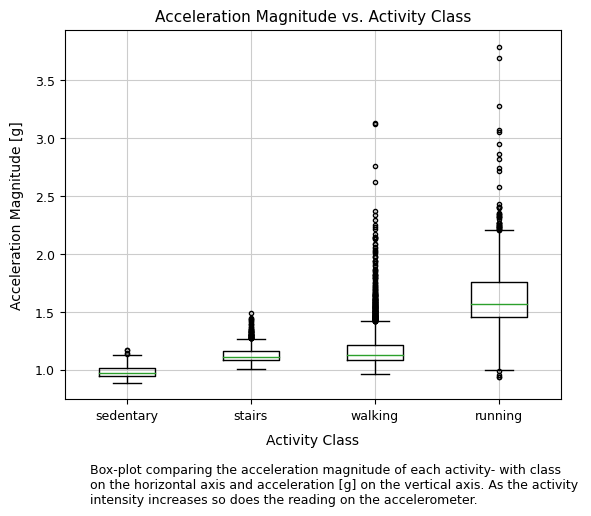

In [12]:
# time domain accl. magnitude vs. activity class boxplots

acclmag_caption = """Box-plot comparing the acceleration magnitude of each activity- with class 
on the horizontal axis and acceleration [g] on the vertical axis. As the activity 
intensity increases so does the reading on the accelerometer."""

file_name = 'acclmag-activity-boxplot.png'

build_grouped_boxplots(df=time_domain_df, group_feature='class', agg_feature='td_mean_m',
                       group_custom_order=class_custom_order, plot_title='Acceleration Magnitude vs. Activity Class',
                       xlabel='Activity Class', ylabel='Acceleration Magnitude [g]',
                       caption=acclmag_caption, file_name=file_name)


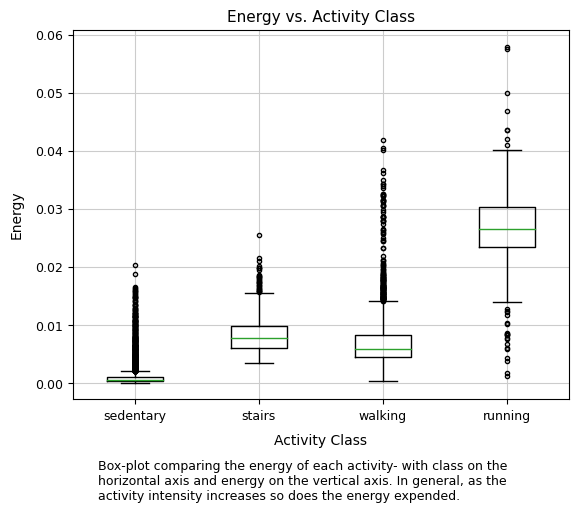

In [13]:
# time domain energy vs. activity class boxplots
energy_caption = """Box-plot comparing the energy of each activity- with class on the 
horizontal axis and energy on the vertical axis. In general, as the 
activity intensity increases so does the energy expended."""
    
file_name = 'energy-activity-boxplot.png'

build_grouped_boxplots(df=time_domain_df, group_feature='class', agg_feature='td_energy',
                       group_custom_order=class_custom_order, plot_title='Energy vs. Activity Class',
                       xlabel='Activity Class', ylabel='Energy',
                       caption=energy_caption, caption_position=(0.7, -0.02),
                       file_name=file_name)


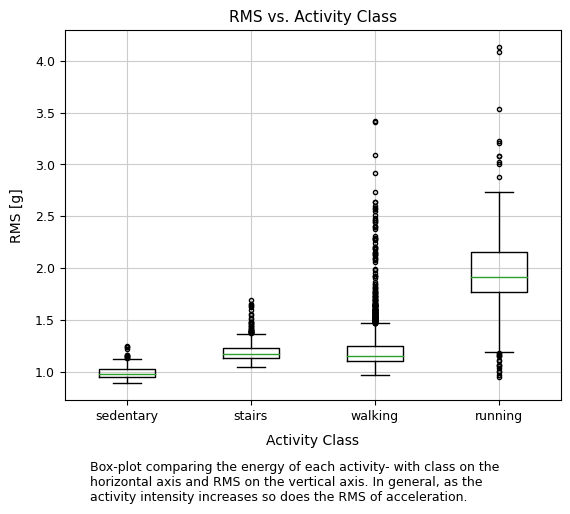

In [14]:
# time domain RMS vs. activity class boxplots

rms_caption = """Box-plot comparing the energy of each activity- with class on the 
horizontal axis and RMS on the vertical axis. In general, as the 
activity intensity increases so does the RMS of acceleration."""

file_name = 'rms-activity-boxplot.png'

build_grouped_boxplots(df=time_domain_df, group_feature='class', agg_feature='td_rms_m',
                       group_custom_order=class_custom_order, plot_title='RMS vs. Activity Class',
                       xlabel='Activity Class', ylabel='RMS [g]',
                       caption=rms_caption, caption_position=(0.7, -0.25),
                       file_name=file_name)


##### 4.4 Frequency domain plots

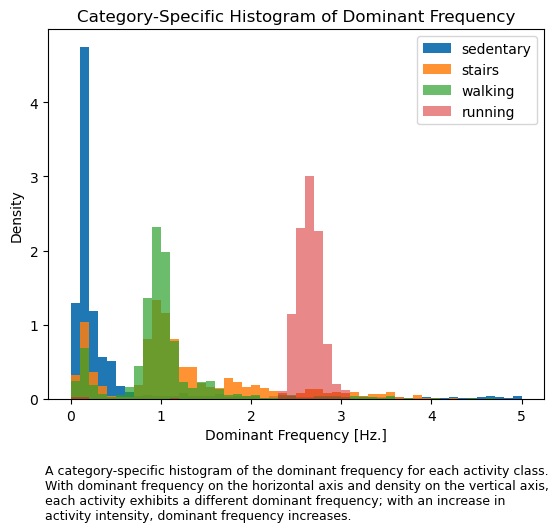

In [15]:
cat_hist_df = freq_domain_df.sort_values(['class'],key= lambda x: x.map(class_custom_order))
classes = cat_hist_df['class'].unique()

for i,c in enumerate(classes):
    plt.hist(cat_hist_df[cat_hist_df['class']==c]['fd_dominant_freq_x'], alpha=1-i*0.15, label=c,
             density=True, bins=50, range=(0,5))
plt.title('Category-Specific Histogram of Dominant Frequency')
plt.xlabel('Dominant Frequency [Hz.]')
plt.ylabel('Density')
plt.legend()

caption_text = r"""A category-specific histogram of the dominant frequency for each activity class.
With dominant frequency on the horizontal axis and density on the vertical axis,
each activity exhibits a different dominant frequency; with an increase in 
activity intensity, dominant frequency increases."""

plt.figtext(0.12, -0.14, caption_text, wrap=False, horizontalalignment='left',
            fontsize=9)

file_name = 'cat-hist-dominant-freq.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")


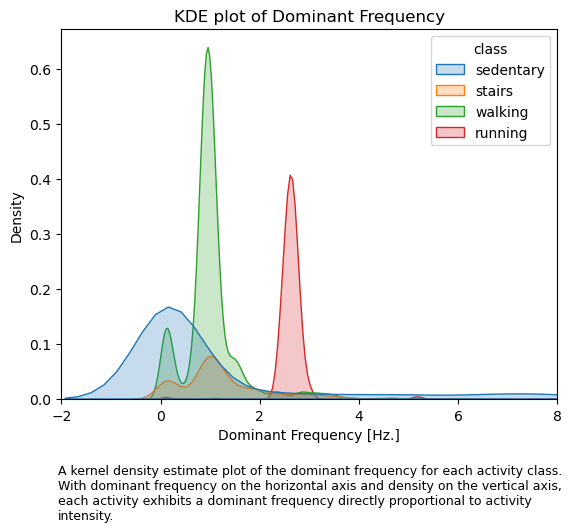

In [16]:
import seaborn as sns

fig, ax = plt.subplots()
kde = sns.kdeplot(data=cat_hist_df, x='fd_dominant_freq_x', hue='class',fill=True, ax=ax)
ax.set_xlim(-2,8)
ax.set_xlabel('Dominant Frequency [Hz.]')
ax.set_title('KDE plot of Dominant Frequency')

caption_text = r"""A kernel density estimate plot of the dominant frequency for each activity class.
With dominant frequency on the horizontal axis and density on the vertical axis,
each activity exhibits a dominant frequency directly proportional to activity 
intensity."""

plt.figtext(0.12, -0.14, caption_text, wrap=False, horizontalalignment='left',
            fontsize=9)

file_name = 'kde-dominant-freq.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
plt.show()


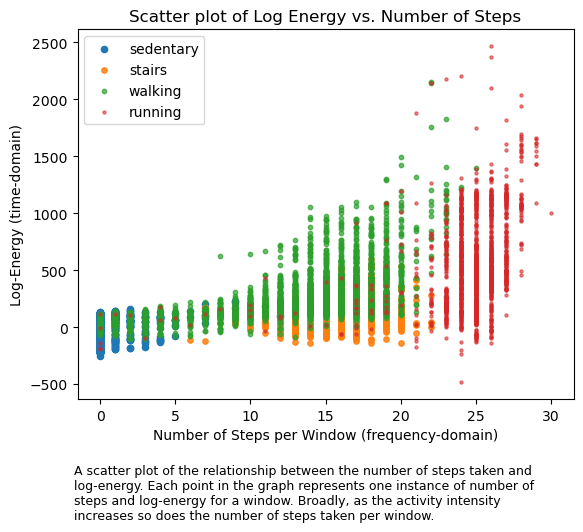

In [17]:
label_color_map = build_label_color_map(class_labels = time_freq_domain_df['class'].unique().tolist())

cat_scat_df = time_freq_domain_df.sort_values(['class'],key= lambda x: x.map(class_custom_order))
classes = cat_scat_df['class'].unique()

fig, ax = plt.subplots()

for i,c in enumerate(classes):
    ax.scatter(cat_scat_df[cat_scat_df['class']==c]['fd_step_counter_m'], 
                cat_scat_df[cat_scat_df['class']==c]['td_log_power_m'],
                alpha=1-i*0.15, label=c, s=20-i*5)
    
ax.set_title('Scatter plot of Log Energy vs. Number of Steps')
ax.set_xlabel('Number of Steps per Window (frequency-domain)')
ax.set_ylabel('Log-Energy (time-domain)')

caption_text = r"""A scatter plot of the relationship between the number of steps taken and
log-energy. Each point in the graph represents one instance of number of 
steps and log-energy for a window. Broadly, as the activity intensity 
increases so does the number of steps taken per window."""

ax.legend()

plt.figtext(0.12, -0.14, caption_text, wrap=False, horizontalalignment='left',
            fontsize=9)

file_name = 'scat-logenergy-numsteps.png'
plt.savefig(os.path.join('../figures', file_name), dpi=300, bbox_inches="tight")
